<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.981 · TFM Àrea 4 · NLP & Text Mining</p>
<p style="margin: 0; text-align:right;">2022 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

<div class="row" style="padding-top: 50px;">
    <div class="row" style="background: #494949;padding: 10px 20px; color: #FFF">
        <div class="col-md-12">
            <div style="text-align:left;"><b>Estudiant:</b> Albert Cámara Viñals</div>
        </div>
    </div>
</div>


# Invoice Synthetic dataset preparation

In [1]:
# Load libraries
import cv2
import glob
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import shutil

from IPython import display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from xml.etree import ElementTree as ET

plt.style.use("ggplot")

%matplotlib inline

**Define work directories**

In [2]:
# Define some directories
data_dir = './data/'
dataset_path = './data/synthetic_invoice/'

## Data Objects

In [3]:
# Dictionary of Invoice attributes

invoice_attributes = { 
    'BA': {'description':  'Billing Address', 'tag': 'BILLING_ADDRESS'},
    'BCN': {'description':  'Billing Contact Number', 'tag': 'BILLING_CONTACT_NUMBER'},
    'BN': {'description':  'Billing Name', 'tag': 'BILLING_NAME'},
    'CNUM': {'description': 'Client Number', 'tag': 'CLIENT_NUMBER'},
    'EN': {'description':  'E-commerce Platform Name (Like Amazon, Ebay,..)', 'tag': 'ECOMMERCE_PLATFORM_NAME'},  
    'EOID': {'description':  'E-commerce Order Reference', 'tag': 'ECOMMERCE_ORDER_REFERENCE'},
    'EWEB': {'description':  'E-commerce Platform Website', 'tag': 'ECOMMERCE_PLATFORM_WEBSITE'},
    'IDATE': {'description':  'Invoice Date', 'tag': 'INVOICE_DATE'},
    'img': {'description':  'Image', 'tag': 'IMAGE'},
    'IN': {'description': 'Invoice Number', 'tag': 'INVOICE_NUMBER'},
    'ONUM': {'description':  'Order Number', 'tag': 'ORDER_NUMBER'},
    'PD': {'description':  'Product Description', 'tag': 'PRODUCT_DESCRIPTION'},
    'PMODE': {'description':  'Payment Mode', 'tag': 'PAYMENT_MODE'},
    'PT': {'description': 'Product Total', 'tag': 'PRODUCT_TOTAL'},
    'PTTX': {'description': 'Product Total Price with TAX', 'tag': 'PRODUCT_TOTAL_PRICE_WITH_TAX'},
    'PTWTX': {'description': 'Product Total Price without TAX', 'tag': 'PRODUCT_TOTAL_PRICE_WITHOUT_TAX'},
    'QTY': {'description':  'Quantity', 'tag': 'QUANTITY'},
    'SA': {'description':  'Seller Address', 'tag': 'SUPPLIER_ADDRESS'},
    'SCID': {'description':  'Seller Identifier Number (Siren)', 'tag': 'SUPPLIER_ID'},
    'SCN': {'description':  'Seller Contact Number', 'tag': 'SUPPLIER_CONTACT_NUMBER'}, 
    'SEMAIL': {'description':  'Seller Email', 'tag': 'SUPPLIER_EMAIL'},
    'SFAX': {'description':  'Seller Fax Number', 'tag': 'SUPPLIER_FAX_NUMBER'},
    'SHA': {'description':  'Shipping Address', 'tag': 'SHIPPING_ADDRESS'},
    'SHCN': {'description':  'Shipping Contact Number', 'tag': 'SHIPPING_CONTACT_NUMBER'},
    'SHN': {'description':  'Shipping Name', 'tag': 'SHIPPING_NAME'},
    'SN': {'description':  'Seller/Company) name', 'tag': 'SUPPLIER_NAME'},
    'SNO': {'description': 'SNO', 'tag': 'SNO'},
    'SRCS': {'description':  'Seller RCS', 'tag': 'SUPPLIER_RCS'},
    'SSIRET': {'description':  'Seller Siret', 'tag': 'SUPPLIER_SIRET'},
    'STOA': {'description':  'Seller TOA/APE', 'tag': 'SUPPLIER_TOA'},
    'SVAT': {'description':  'Seller Vat Number/TVA', 'tag': 'SUPPLIER_VAT'}, 
    'SWEB': {'description':  'Seller Website', 'tag': 'SUPPLIER_WEBSITE'},
    'TA': {'description': 'Total with TAX', 'tag': 'TOTAL_AMOUNT'},
    'TBL': {'description':  'Table (and its content)', 'tag': 'TABLE'},
    'TPDATE': {'description':  'Tax Point Date (date of supply)', 'tag': 'TAX_POINT_DATE'}, 
    'TTX': {'description': 'Total Tax', 'tag': 'TOTAL_TAX'},
    'TWTX': {'description':  'TWTXS', 'tag': 'TOTAL_WITHOUT_TAX'},
    'TXR': {'description': 'Tax Rate', 'tag': 'TAX_RATE'},
    'UP': {'description': 'Unit Price Without Tax', 'tag': 'UNIT_PRICE'},
    'undefined': {'description':  'OTHER', 'tag': 'OTHER'},
}

In [4]:
# Save dict of Invoice attributes to file
invoice_attributes_file = open(os.path.join(data_dir, 'invoice_attributes.pickle'), "wb")
pickle.dump(invoice_attributes, invoice_attributes_file)
invoice_attributes_file.close()

In [5]:
# Get only tags of the dictionary
tags = [v['tag'] for k,v in invoice_attributes.items()]

# Sort tags
tags.sort()

# Previw tags
print(tags)

['BILLING_ADDRESS', 'BILLING_CONTACT_NUMBER', 'BILLING_NAME', 'CLIENT_NUMBER', 'ECOMMERCE_ORDER_REFERENCE', 'ECOMMERCE_PLATFORM_NAME', 'ECOMMERCE_PLATFORM_WEBSITE', 'IMAGE', 'INVOICE_DATE', 'INVOICE_NUMBER', 'ORDER_NUMBER', 'OTHER', 'PAYMENT_MODE', 'PRODUCT_DESCRIPTION', 'PRODUCT_TOTAL', 'PRODUCT_TOTAL_PRICE_WITHOUT_TAX', 'PRODUCT_TOTAL_PRICE_WITH_TAX', 'QUANTITY', 'SHIPPING_ADDRESS', 'SHIPPING_CONTACT_NUMBER', 'SHIPPING_NAME', 'SNO', 'SUPPLIER_ADDRESS', 'SUPPLIER_CONTACT_NUMBER', 'SUPPLIER_EMAIL', 'SUPPLIER_FAX_NUMBER', 'SUPPLIER_ID', 'SUPPLIER_NAME', 'SUPPLIER_RCS', 'SUPPLIER_SIRET', 'SUPPLIER_TOA', 'SUPPLIER_VAT', 'SUPPLIER_WEBSITE', 'TABLE', 'TAX_POINT_DATE', 'TAX_RATE', 'TOTAL_AMOUNT', 'TOTAL_TAX', 'TOTAL_WITHOUT_TAX', 'UNIT_PRICE']


**Define some functions**

In [6]:
# Function to mask text
def mask_content(text):
    masked_alphabetic = re.sub(r'[A-Za-zÀ-ÖØ-öø-ÿ]', r'A', text)
    masked_digits = re.sub(r'\d', r'N', masked_alphabetic)
    masked_text = re.sub(r'\W', r'S', masked_digits)
    return masked_text

In [7]:
# Function to read GEDI-XML file and convert to PANDAS dataframe
def process_gedi_file(filename):
    
    document = ET.parse(filename).getroot()

    # dictionary 
    invoice = {} 

    dl_documents = document.findall("DL_DOCUMENT")
    
    for dl_document in dl_documents:
        src = dl_document.get('src')
        num_pages = dl_document.get('NrOfPages')

        for dl_page in dl_document.iter("DL_PAGE"):
            page_id = dl_page.get('pageID')
            page_width = dl_page.get('width')
            page_height = dl_page.get('height')
            
            dl_zones = dl_page.findall("DL_ZONE")

            for idx, dl_zone in enumerate(dl_zones):
                invoice[idx] = {} 
                
                col =  int(dl_zone.get('col'))
                row = int(dl_zone.get('row'))
                width = int(dl_zone.get('width'))
                height = int(dl_zone.get('height'))
                correctclass = dl_zone.get('correctclass')
                
                invoice[idx]['src'] = src
                invoice[idx]['num_pages'] = int(num_pages)
                invoice[idx]['page_id'] = int(page_id)
                invoice[idx]['page_width'] = int(page_width)
                invoice[idx]['page_height'] = int(page_height)
                invoice[idx]['id'] = dl_zone.get('id')
                invoice[idx]['col'] = col
                invoice[idx]['row'] = row
                invoice[idx]['width'] = width
                invoice[idx]['height'] = height
                invoice[idx]['x1'] = col
                invoice[idx]['y1'] = row
                invoice[idx]['x2'] = col + width
                invoice[idx]['y2'] = row
                invoice[idx]['x3'] = col + width
                invoice[idx]['y3'] = row + height
                invoice[idx]['x4'] = col 
                invoice[idx]['y4'] = row + height
                invoice[idx]['contents'] = dl_zone.get('contents')
                invoice[idx]['contents_masked'] = mask_content(dl_zone.get('contents'))
                invoice[idx]['correctclass'] = correctclass
                invoice[idx]['tag'] = invoice_attributes[correctclass]['tag']
                invoice[idx]['description'] = invoice_attributes[correctclass]['description']
    
    # Create pandas dataframe from invoice object
    df = pd.DataFrame(invoice).transpose()
    
    # Drop some duplicate values (duplicate gedi fields)
    df.drop_duplicates(subset=['num_pages', 'page_id', 'page_width', 'page_height', 'col', 'row', 'width', 'height', 'contents'], keep='first', inplace=True)
    
    # Delete rows with text outside of page
    df = df[df['x1'] > 0]
    df = df[df['x3'] < df['page_width']]
    #df = df[df['y3'] < df['page_height']]
    
    # Delete rows with null content and reset index
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    return df

In [8]:
# Function to draw bounding boxes in images
def draw_bouding_boxes(image, data, color):
    image = cv2.imread(image)

    for index, row in data.iterrows():
        cv2.rectangle(image, (row["x1"], row["y1"]), (row["x3"], row["y3"]), color)
           
    return image

# Function to draw bounding boxes and labels in images
def draw_bouding_boxes_and_labels(image, data, color, color_text, thickness, thickness_text):
    image = cv2.imread(image)

    for index, row in data.iterrows():
        cv2.rectangle(image, (row["x1"], row["y1"]), (row["x3"], row["y3"]), color, thickness)
        cv2.putText(image, row['tag'], (row["x1"], row["y1"]), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color_text, thickness_text)
    
    return image

# Function to preview image
def show_image(image):   
    cv2.imshow('image', image)
    #cv2.namedWindow("PREVIEW", cv2.WINDOW_NORMAL)  # Create window with freedom of dimensions
    #image_resized = cv2.resize(image, (595, 842))  # Resize image
    #cv2.imshow("PREVIEW", image_resized)           # Show image
    cv2.waitKey(0)                                  # Display the image infinitely until any keypress

In [9]:
# Function to process directory with invoices
def process_directory(data_dir, data_transformed_dir):
    print('Processing files...')
    if not os.path.isdir(data_transformed_dir):
        os.makedirs(data_transformed_dir)

    # Get list of all files
    image_files = glob.glob(data_dir + "*.tiff")
    gedi_files = glob.glob(data_dir + "*.xml")
    pdf_files = glob.glob(data_dir + "*.pdf")

    # Show number of files
    #print(image_files) 
    #print(pdf_files) 

    # Loop all files and process
    for gedi_file in gedi_files:
        # Get filepath
        base = os.path.basename(gedi_file)

        # Get basename
        basename = os.path.splitext(base)[0]
        
        # Copy Original files
        shutil.copy(gedi_file, data_transformed_dir)
        shutil.copy(data_dir + basename + '.tiff', data_transformed_dir)
        shutil.copy(data_dir + basename + '.pdf', data_transformed_dir)

        # Read GEDI-XML into pandas dataframe
        df = process_gedi_file(gedi_file)

        # Sort dataframe by top row and top column (0,0) (left, top)
        df.sort_values(by=['row', 'col'], inplace=True, ascending = [True, True])

        # Save dataframe
        df.to_csv(os.path.join(data_transformed_dir, basename + '.csv'), index = False, sep=';')
        
    print('Number of files: ', len(gedi_files))

**Process a single invoice file (as example)**

In [10]:
data_dir = 'data/examples/'
basename = 'invoice-1'

# Read GEDI-XML into pandas dataframe
df = process_gedi_file(os.path.join(data_dir, basename + '.xml'))

# Sort dataframe by top row and top column (0,0) (left, top)
df.sort_values(by=['row', 'col'], inplace=True, ascending = [True, True])

# Save dataframe
df.to_csv(os.path.join(data_dir, basename + '.csv'), index = False, sep=';')

# Preview dataframe
df.head(10)

,src,num_pages,page_id,page_width,page_height,id,col,row,width,height,...,y2,x3,y3,x4,y4,contents,contents_masked,correctclass,tag,description
0,invoice-1.tiff,1,1,2480,3508,1,124,62,175,175,...,62,299,237,124,237,common/logo,AAAAAASAAAA,img,IMAGE,Image
23,invoice-1.tiff,1,1,2480,3508,24,1541,258,108,59,...,258,1649,317,1541,317,Date,AAAA,undefined,OTHER,OTHER
24,invoice-1.tiff,1,1,2480,3508,25,1712,258,66,52,...,258,1778,310,1712,310,abr,AAA,IDATE,INVOICE_DATE,Invoice Date
25,invoice-1.tiff,1,1,2480,3508,26,1791,258,38,52,...,258,1829,310,1791,310,"7,",NS,IDATE,INVOICE_DATE,Invoice Date
26,invoice-1.tiff,1,1,2480,3508,27,1842,258,101,52,...,258,1943,310,1842,310,1979,NNNN,IDATE,INVOICE_DATE,Invoice Date
1,invoice-1.tiff,1,1,2480,3508,2,124,412,53,49,...,412,177,461,124,461,LE,AA,SN,SUPPLIER_NAME,Seller/Company) name
2,invoice-1.tiff,1,1,2480,3508,3,189,412,134,49,...,412,323,461,189,461,HIBOU,AAAAA,SN,SUPPLIER_NAME,Seller/Company) name
3,invoice-1.tiff,1,1,2480,3508,4,124,510,115,48,...,510,239,558,124,558,73150,NNNNN,SA,SUPPLIER_ADDRESS,Seller Address
4,invoice-1.tiff,1,1,2480,3508,5,282,510,78,48,...,510,360,558,282,558,VAL,AAA,SA,SUPPLIER_ADDRESS,Seller Address
5,invoice-1.tiff,1,1,2480,3508,6,372,510,163,48,...,510,535,558,372,558,D'ISERE,ASAAAAA,SA,SUPPLIER_ADDRESS,Seller Address


In [11]:
# Compute frequency on each one of classes for class attribute 'TAG'
df["tag"].value_counts()

OTHER                      54
SUPPLIER_ADDRESS            8
BILLING_ADDRESS             8
SHIPPING_ADDRESS            8
SUPPLIER_CONTACT_NUMBER     7
SUPPLIER_FAX_NUMBER         7
SUPPLIER_NAME               4
INVOICE_DATE                3
BILLING_NAME                2
SHIPPING_NAME               2
PAYMENT_MODE                2
IMAGE                       1
INVOICE_NUMBER              1
TOTAL_WITHOUT_TAX           1
TOTAL_TAX                   1
TOTAL_AMOUNT                1
Name: tag, dtype: int64

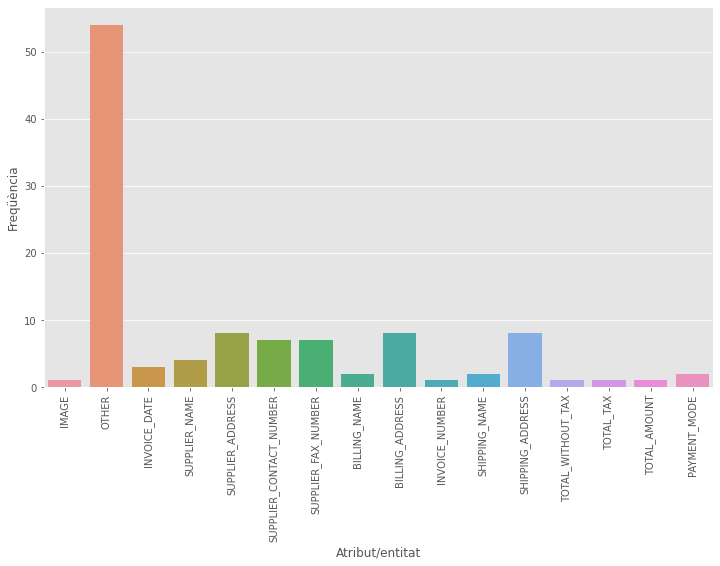

In [12]:
# Create barchart for class attribute 'TAG'
plt.figure(figsize=(12, 7))
g1 = sns.countplot(x="tag", data=df)
plt.xlabel('Atribut/entitat')
plt.ylabel('Freqüència')
plt.xticks(rotation='vertical')

obs = len(df);

# Add tags to graph
for p, label in zip(g1.patches, df["tag"].value_counts().index):
    g1.annotate(str(p.get_height()) + ' (' + str(round(p.get_height()/obs*100, 2)) + '%)' , (p.get_x() + 0.05, p.get_height() + 1500))

In [13]:
# Draw GEDI-XML bounding boxes and preview image
image = draw_bouding_boxes(os.path.join(data_dir, basename + '.tiff'), df, (255, 0, 0))

#show_image(image)

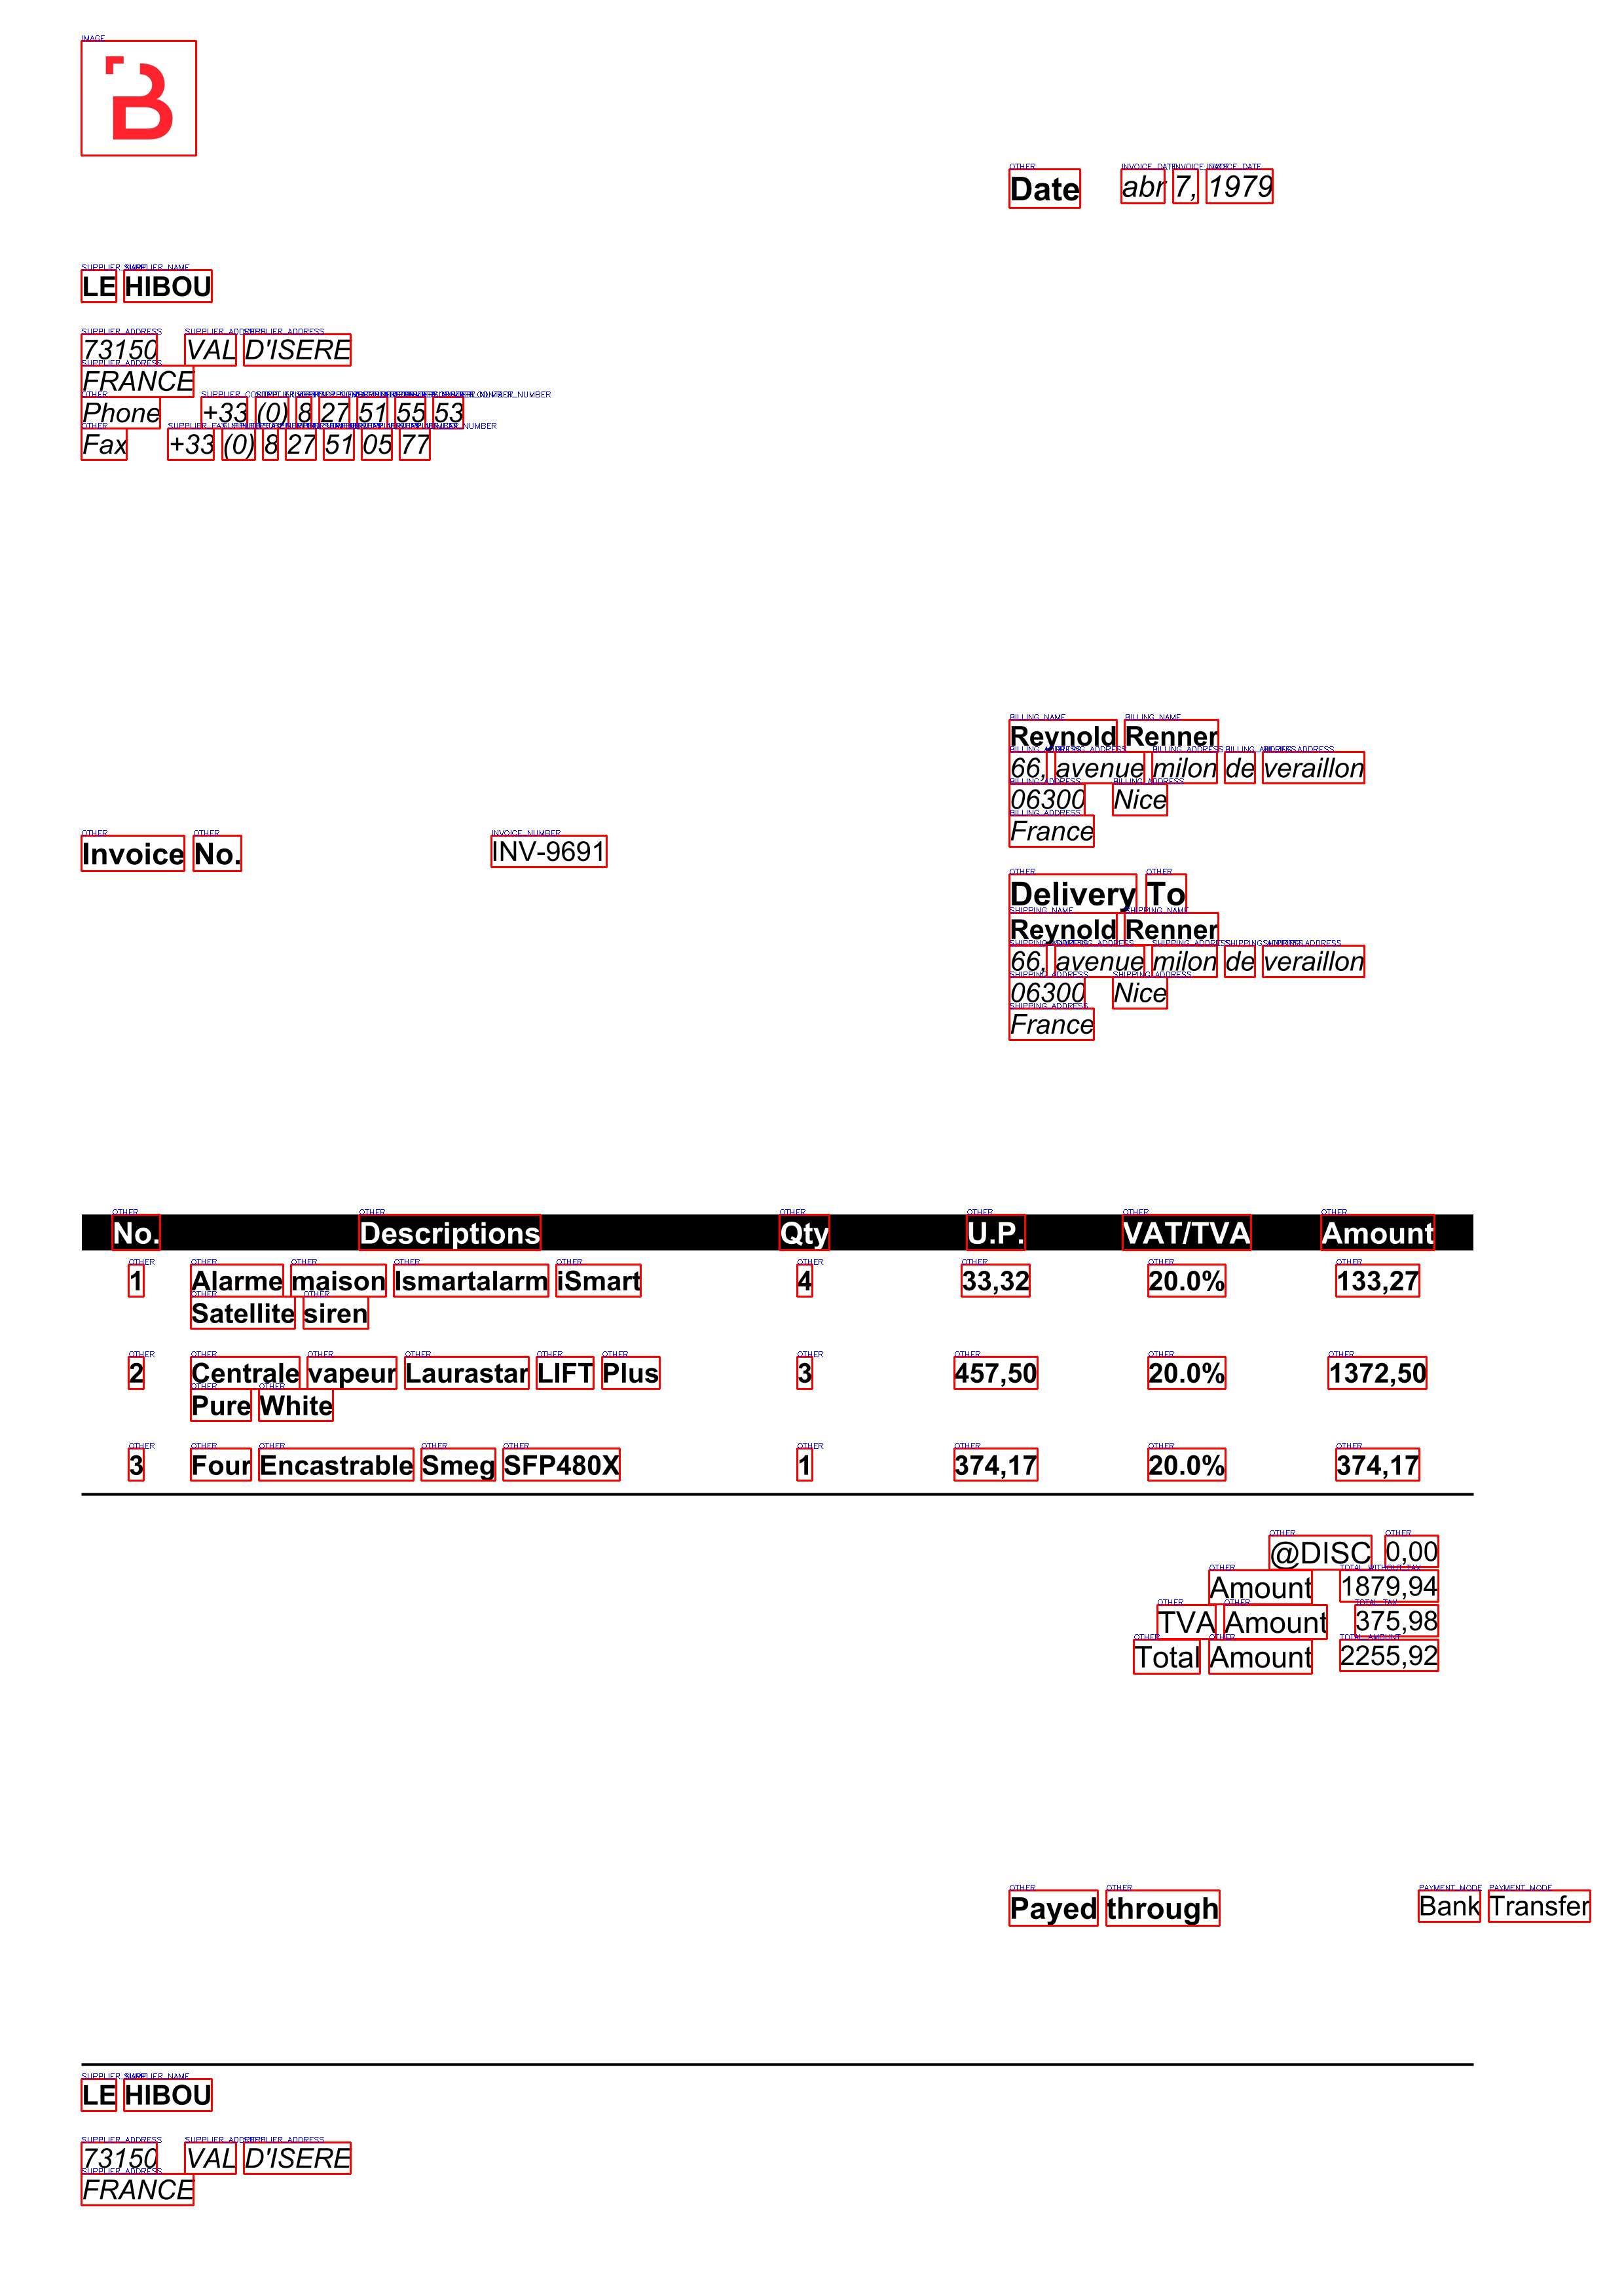

In [14]:
# Draw bounding boxes and labels. Then preview image
image = draw_bouding_boxes_and_labels(os.path.join(data_dir, basename + '.tiff'), df, (0, 0, 255), (255,0, 0), 2, 1)

# Write image with bounding boxes, labels and relationships
cv2.imwrite(os.path.join(data_dir, basename + '-boxes_and_labels.png'), image)

#show_image(image)

display.Image(os.path.join(data_dir, basename + '-boxes_and_labels.png'))

**Process a batch of invoice files from multiple providers**

In [15]:
# Process multiple directories of Invoices
process_directory('./data/synthetic_invoice/original/amazon/', './data/synthetic_invoice/transformed/amazon/')
process_directory('./data/synthetic_invoice/original/bdmobilier/', './data/synthetic_invoice/transformed/bdmobilier/')
process_directory('./data/synthetic_invoice/original/cdiscount/', './data/synthetic_invoice/transformed/cdiscount/')
process_directory('./data/synthetic_invoice/original/darty/', './data/synthetic_invoice/transformed/darty/')
process_directory('./data/synthetic_invoice/original/ldlc/', './data/synthetic_invoice/transformed/ldlc/')
process_directory('./data/synthetic_invoice/original/materialnet/', './data/synthetic_invoice/transformed/materialnet/')
process_directory('./data/synthetic_invoice/original/naturedecouvertes/', './data/synthetic_invoice/transformed/naturedecouvertes/')

Processing files...
Number of files:  250
Processing files...
Number of files:  250
Processing files...
Number of files:  250
Processing files...
Number of files:  250
Processing files...
Number of files:  250
Processing files...
Number of files:  250
Processing files...
Number of files:  250


**Build a Dataset Description File**

In [16]:
# Get list of all files
files = glob.glob(dataset_path + "/transformed/*/*.csv")

def get_num_words_of_doc(file):
    df = pd.read_csv(file, sep=';')
    return df.shape[0]
    
num_docs = len(files)
num_words_docs = [get_num_words_of_doc(file) for file in files]

print('Number of Documents: ', num_docs)
print('Number of Words: ', sum(num_words_docs))
print('Mean of Words by documents: ', np.mean(num_words_docs))

Number of Documents:  1750
Number of Words:  347092
Mean of Words by documents:  198.33828571428572


In [17]:
# Create a sample Dataframe with filenames and document types
filenames = [os.path.splitext(os.path.basename(file))[0] + '.csv' for file in files] 
images = [os.path.splitext(os.path.basename(file))[0] + '.tiff' for file in files]
pdfs = [os.path.splitext(os.path.basename(file))[0] + '.pdf' for file in files]
gedi_files = [os.path.splitext(os.path.basename(file))[0] + '.xml' for file in files]
providers = [os.path.basename(os.path.dirname(file)) for file in files]

data = pd.DataFrame({'type': 'invoice', 'file': filenames, 'image': images, 'pdf': pdfs, 'gedi': gedi_files, 'provider': providers, 'words': num_words_docs})

data.to_csv(os.path.join(dataset_path, 'samples_list.csv'), index = False, sep=';')

In [18]:
# Explore sample dataframe (document_type, file_name)
samples_list = pd.read_csv(os.path.join(dataset_path, 'samples_list.csv'), dtype=str, sep=';')
samples_list.head()

,type,file,image,pdf,gedi,provider,words
0,invoice,amazon-1.csv,amazon-1.tiff,amazon-1.pdf,amazon-1.xml,amazon,169
1,invoice,amazon-10.csv,amazon-10.tiff,amazon-10.pdf,amazon-10.xml,amazon,183
2,invoice,amazon-100.csv,amazon-100.tiff,amazon-100.pdf,amazon-100.xml,amazon,195
3,invoice,amazon-101.csv,amazon-101.tiff,amazon-101.pdf,amazon-101.xml,amazon,173
4,invoice,amazon-102.csv,amazon-102.tiff,amazon-102.pdf,amazon-102.xml,amazon,205
